# Linear Classification with Softmax Loss

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [5]:
import time
import random
import numpy as np
from dl4cv.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the code line by line so that you understand the general preprocessing pipeline.
The whole datasat is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).
Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [6]:
from dl4cv.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

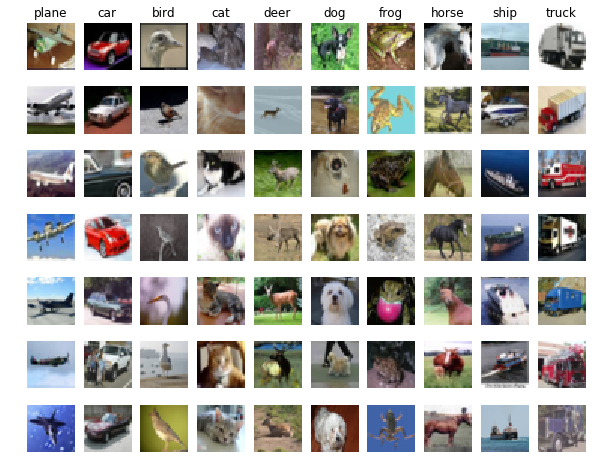

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()
#print('hello')

In [8]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]


# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [9]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64297917  135.92841667  132.4100625   130.0744375   135.3130625
  131.70479167  131.0373125   136.18741667  132.48804167  131.65420833]


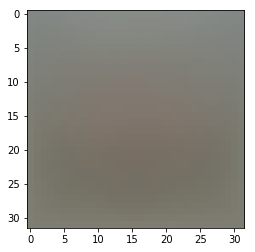

In [10]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [11]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [12]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

Your code for this section will all be written inside `dl4cv/classifiers/softmax.py`. 
You will implement the gradient of the loss function with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement the naive softmax loss function with nested loops.
Open the file `dl4cv/classifiers/softmax.py` and implement the softmax_loss_naive function.
Running this method might take a while...

In [67]:
from dl4cv.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.350385
sanity check: 2.302585


### Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.

**Your answer:** *We expect that the posterior probabilities for every example data is distributed uniformly amongst all class, i.e it is 0.1*


In [14]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from dl4cv.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 1.287771 analytic: 1.287771, relative error: 7.224570e-08
numerical: -0.402956 analytic: -0.402956, relative error: 7.112554e-08


numerical: 2.077005 analytic: 2.077005, relative error: 2.106509e-08


numerical: -2.489115 analytic: -2.491707, relative error: 5.203547e-04
numerical: 0.129861 analytic: 0.138116, relative error: 3.080512e-02


numerical: -0.384103 analytic: -0.376650, relative error: 9.796241e-03


### Vectorized Implementation
Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized.
The two versions should compute the same results, but the vectorized version should be much faster.

In [15]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from dl4cv.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.395655e+00 computed in 0.117528s
vectorized loss: 2.395655e+00 computed in 0.023064s
Loss difference: 0.000000
Gradient difference: 0.000000


### Inline Question 2:
When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?

(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)

**Your answer:** *Multiplying and dividing by exp(maximum of all predicted scores) might help. In the sum of exponentials in the denominator, we will get exp(output(i) - max(output)) for every predicted score, also one of the components would be exp(0)=1, so the denominator will not be close to zero either*


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [34]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from dl4cv.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=2.7e-6, reg=1e3,
                      num_iters=3000, batch_size=550, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 3000: loss 20.510337


iteration 100 / 3000: loss 10.820661


iteration 200 / 3000: loss 6.870052


iteration 300 / 3000: loss 4.707961


iteration 400 / 3000: loss 3.419968


iteration 500 / 3000: loss 2.698033


iteration 600 / 3000: loss 2.351590


iteration 700 / 3000: loss 2.193175


iteration 800 / 3000: loss 2.018435


iteration 900 / 3000: loss 1.863960


iteration 1000 / 3000: loss 1.860600


iteration 1100 / 3000: loss 1.851642


iteration 1200 / 3000: loss 1.810069


iteration 1300 / 3000: loss 1.838082


iteration 1400 / 3000: loss 1.772625


iteration 1500 / 3000: loss 1.824171


iteration 1600 / 3000: loss 1.781304


iteration 1700 / 3000: loss 1.783616


iteration 1800 / 3000: loss 1.771512


iteration 1900 / 3000: loss 1.780129


iteration 2000 / 3000: loss 1.890580


iteration 2100 / 3000: loss 1.772482


iteration 2200 / 3000: loss 1.798466


iteration 2300 / 3000: loss 1.751600


iteration 2400 / 3000: loss 1.765417


iteration 2500 / 3000: loss 1.834815


iteration 2600 / 3000: loss 1.822617


iteration 2700 / 3000: loss 1.780355


iteration 2800 / 3000: loss 1.747922


iteration 2900 / 3000: loss 1.860514


That took 131.619372s


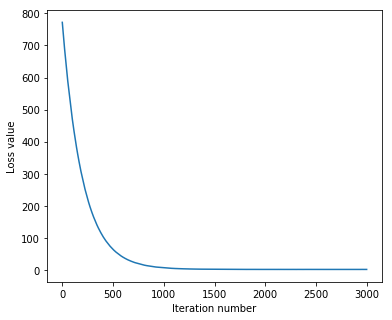

In [17]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [69]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
from dl4cv.classifiers.linear_classifier import Softmax
y_train_pred = softmax.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = softmax.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

softmax1 = Softmax()
#softmax1.loss1()
zeroMatrix = softmax1.test()

training accuracy: 0.350917
validation accuracy: 0.353000
crazzy


### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength, learning rate and possibly batch size). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set.

In [42]:
from dl4cv.classifiers import Softmax

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = None
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [5e4, 1e5]
learning_rates = [3e-7,5e-7,1e-6,2.3e-6,2.7e-6,3e-6]#[1e-10,5e-10,1e-9,5e-9,1e-8,5e-8,1e-7,5e-7]
regularization_strengths = [0.8e3,1e3,1.3e3,3e3,5e3]#[1e1,5e1,1e2,5e2,1e3,5e3,1e4,5e4,1e5,5e5]

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a classifier on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this    #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train;       # 
# once you are confident that your validation code works, you should rerun     #
# the validation code with a larger value for num_iters.                       #
################################################################################
#pass
best_vals = (0,0)
best_key = (0,0)
for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):

        softmax = Softmax()
        tic = time.time()
        loss_hist = softmax.train(X_train, y_train, learning_rates[i], regularization_strengths[j],
                              num_iters=3000, verbose=True)
        toc = time.time()
        print 'That took %fs' % (toc - tic)        
        
        y_train_pred = softmax.predict(X_train)
        #print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
        y_val_pred = softmax.predict(X_val)
        #print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )
        
        results[(learning_rates[i],regularization_strengths[j])] = (np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred))
        if(best_vals[1] < results[(learning_rates[i],regularization_strengths[j])][1]):
            best_vals = results[(learning_rates[i],regularization_strengths[j])]
            best_key = (learning_rates[i],regularization_strengths[j])
            best_softmax = softmax


print(results.values())


best_val=best_vals[1]
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during validation: %f' % best_val
print('best keys : ',best_key)

iteration 0 / 3000: loss 18.235694


iteration 100 / 3000: loss 14.922646


iteration 200 / 3000: loss 13.966672


iteration 300 / 3000: loss 13.330209


iteration 400 / 3000: loss 12.584013


iteration 500 / 3000: loss 11.976445


iteration 600 / 3000: loss 11.522584


iteration 700 / 3000: loss 10.872277


iteration 800 / 3000: loss 10.546556


iteration 900 / 3000: loss 9.988866


iteration 1000 / 3000: loss 9.570619


iteration 1100 / 3000: loss 9.160314


iteration 1200 / 3000: loss 8.763397


iteration 1300 / 3000: loss 8.323167


iteration 1400 / 3000: loss 8.033718


iteration 1500 / 3000: loss 7.834328


iteration 1600 / 3000: loss 7.494705


iteration 1700 / 3000: loss 7.188582


iteration 1800 / 3000: loss 6.889114


iteration 1900 / 3000: loss 6.674344


iteration 2000 / 3000: loss 6.260618


iteration 2100 / 3000: loss 6.226816


iteration 2200 / 3000: loss 6.045329


iteration 2300 / 3000: loss 5.793740


iteration 2400 / 3000: loss 5.546349


iteration 2500 / 3000: loss 5.448755


iteration 2600 / 3000: loss 5.244414


iteration 2700 / 3000: loss 5.124576


iteration 2800 / 3000: loss 4.866240


iteration 2900 / 3000: loss 4.799609


That took 65.587693s


iteration 0 / 3000: loss 21.047426


iteration 100 / 3000: loss 17.887187


iteration 200 / 3000: loss 16.500524


iteration 300 / 3000: loss 15.229511


iteration 400 / 3000: loss 14.291614


iteration 500 / 3000: loss 13.706929


iteration 600 / 3000: loss 12.841832


iteration 700 / 3000: loss 12.236949


iteration 800 / 3000: loss 11.610483


iteration 900 / 3000: loss 10.833296


iteration 1000 / 3000: loss 10.391839


iteration 1100 / 3000: loss 9.848880


iteration 1200 / 3000: loss 9.290837


iteration 1300 / 3000: loss 8.908307


iteration 1400 / 3000: loss 8.434622


iteration 1500 / 3000: loss 7.903793


iteration 1600 / 3000: loss 7.576966


iteration 1700 / 3000: loss 7.246548


iteration 1800 / 3000: loss 6.923786


iteration 1900 / 3000: loss 6.388618


iteration 2000 / 3000: loss 6.269676


iteration 2100 / 3000: loss 6.101790


iteration 2200 / 3000: loss 5.933949


iteration 2300 / 3000: loss 5.667506


iteration 2400 / 3000: loss 5.315058


iteration 2500 / 3000: loss 5.092057


iteration 2600 / 3000: loss 4.936419


iteration 2700 / 3000: loss 4.705967


iteration 2800 / 3000: loss 4.426030


iteration 2900 / 3000: loss 4.305037


That took 62.311744s


iteration 0 / 3000: loss 26.001675


iteration 100 / 3000: loss 21.755840


iteration 200 / 3000: loss 19.988477


iteration 300 / 3000: loss 18.334668


iteration 400 / 3000: loss 16.859724


iteration 500 / 3000: loss 15.680166


iteration 600 / 3000: loss 14.480240


iteration 700 / 3000: loss 13.467657


iteration 800 / 3000: loss 12.821212


iteration 900 / 3000: loss 11.734516


iteration 1000 / 3000: loss 10.948090


iteration 1100 / 3000: loss 10.479442


iteration 1200 / 3000: loss 9.778824


iteration 1300 / 3000: loss 9.016119


iteration 1400 / 3000: loss 8.565171


iteration 1500 / 3000: loss 8.004914


iteration 1600 / 3000: loss 7.339654


iteration 1700 / 3000: loss 7.029847


iteration 1800 / 3000: loss 6.556320


iteration 1900 / 3000: loss 6.248661


iteration 2000 / 3000: loss 6.004795


iteration 2100 / 3000: loss 5.517101


iteration 2200 / 3000: loss 5.258650


iteration 2300 / 3000: loss 4.964003


iteration 2400 / 3000: loss 4.709074


iteration 2500 / 3000: loss 4.490710


iteration 2600 / 3000: loss 4.358246


iteration 2700 / 3000: loss 4.164767


iteration 2800 / 3000: loss 4.062687


iteration 2900 / 3000: loss 3.808799


That took 64.238570s


iteration 0 / 3000: loss 52.958307


iteration 100 / 3000: loss 41.794480


iteration 200 / 3000: loss 34.702232


iteration 300 / 3000: loss 29.084245


iteration 400 / 3000: loss 24.429970


iteration 500 / 3000: loss 20.557357


iteration 600 / 3000: loss 17.496599


iteration 700 / 3000: loss 14.890444


iteration 800 / 3000: loss 12.692714


iteration 900 / 3000: loss 10.860514


iteration 1000 / 3000: loss 9.278865


iteration 1100 / 3000: loss 8.172189


iteration 1200 / 3000: loss 7.035286


iteration 1300 / 3000: loss 6.169362


iteration 1400 / 3000: loss 5.435892


iteration 1500 / 3000: loss 4.874473


iteration 1600 / 3000: loss 4.396247


iteration 1700 / 3000: loss 3.966922


iteration 1800 / 3000: loss 3.607999


iteration 1900 / 3000: loss 3.377454


iteration 2000 / 3000: loss 3.054272


iteration 2100 / 3000: loss 2.925367


iteration 2200 / 3000: loss 2.829674


iteration 2300 / 3000: loss 2.668656


iteration 2400 / 3000: loss 2.449139


iteration 2500 / 3000: loss 2.378339


iteration 2600 / 3000: loss 2.167088


iteration 2700 / 3000: loss 2.215797


iteration 2800 / 3000: loss 2.174005


iteration 2900 / 3000: loss 2.105813


That took 66.632534s


iteration 0 / 3000: loss 81.827781


iteration 100 / 3000: loss 59.508955


iteration 200 / 3000: loss 44.061755


iteration 300 / 3000: loss 32.967112


iteration 400 / 3000: loss 24.790905


iteration 500 / 3000: loss 18.766090


iteration 600 / 3000: loss 14.353849


iteration 700 / 3000: loss 11.125267


iteration 800 / 3000: loss 8.644227


iteration 900 / 3000: loss 7.014122


iteration 1000 / 3000: loss 5.536336


iteration 1100 / 3000: loss 4.665728


iteration 1200 / 3000: loss 3.904031


iteration 1300 / 3000: loss 3.392185


iteration 1400 / 3000: loss 3.023119


iteration 1500 / 3000: loss 2.631485


iteration 1600 / 3000: loss 2.496670


iteration 1700 / 3000: loss 2.312919


iteration 1800 / 3000: loss 2.250328


iteration 1900 / 3000: loss 2.081345


iteration 2000 / 3000: loss 2.125422


iteration 2100 / 3000: loss 2.065732


iteration 2200 / 3000: loss 2.043274


iteration 2300 / 3000: loss 1.972411


iteration 2400 / 3000: loss 1.943243


iteration 2500 / 3000: loss 1.915733


iteration 2600 / 3000: loss 1.905116


iteration 2700 / 3000: loss 1.879629


iteration 2800 / 3000: loss 1.865626


iteration 2900 / 3000: loss 1.879046


That took 64.702647s


iteration 0 / 3000: loss 17.626719


iteration 100 / 3000: loss 14.496318


iteration 200 / 3000: loss 13.031612


iteration 300 / 3000: loss 11.878487


iteration 400 / 3000: loss 11.252530


iteration 500 / 3000: loss 10.112875


iteration 600 / 3000: loss 9.458578


iteration 700 / 3000: loss 8.994096


iteration 800 / 3000: loss 8.380441


iteration 900 / 3000: loss 7.838125


iteration 1000 / 3000: loss 7.312008


iteration 1100 / 3000: loss 6.815493


iteration 1200 / 3000: loss 6.573229


iteration 1300 / 3000: loss 6.277279


iteration 1400 / 3000: loss 5.829071


iteration 1500 / 3000: loss 5.414328


iteration 1600 / 3000: loss 5.123948


iteration 1700 / 3000: loss 4.840788


iteration 1800 / 3000: loss 4.577016


iteration 1900 / 3000: loss 4.258340


iteration 2000 / 3000: loss 4.241519


iteration 2100 / 3000: loss 3.919693


iteration 2200 / 3000: loss 3.678454


iteration 2300 / 3000: loss 3.768847


iteration 2400 / 3000: loss 3.411061


iteration 2500 / 3000: loss 3.417223


iteration 2600 / 3000: loss 3.201826


iteration 2700 / 3000: loss 3.191247


iteration 2800 / 3000: loss 2.985758


iteration 2900 / 3000: loss 2.996538


That took 66.775879s


iteration 0 / 3000: loss 21.452460


iteration 100 / 3000: loss 16.909299


iteration 200 / 3000: loss 14.826003


iteration 300 / 3000: loss 13.612852


iteration 400 / 3000: loss 12.515908


iteration 500 / 3000: loss 11.499472


iteration 600 / 3000: loss 10.564996


iteration 700 / 3000: loss 9.642239


iteration 800 / 3000: loss 8.688388


iteration 900 / 3000: loss 7.973295


iteration 1000 / 3000: loss 7.364115


iteration 1100 / 3000: loss 6.740379


iteration 1200 / 3000: loss 6.304822


iteration 1300 / 3000: loss 5.896280


iteration 1400 / 3000: loss 5.576115


iteration 1500 / 3000: loss 5.190097


iteration 1600 / 3000: loss 4.836946


iteration 1700 / 3000: loss 4.417095


iteration 1800 / 3000: loss 4.208250


iteration 1900 / 3000: loss 4.069804


iteration 2000 / 3000: loss 3.894333


iteration 2100 / 3000: loss 3.598086


iteration 2200 / 3000: loss 3.462889


iteration 2300 / 3000: loss 3.197274


iteration 2400 / 3000: loss 3.090360


iteration 2500 / 3000: loss 3.133270


iteration 2600 / 3000: loss 2.979721


iteration 2700 / 3000: loss 2.616779


iteration 2800 / 3000: loss 2.652481


iteration 2900 / 3000: loss 2.495776


That took 69.645106s


iteration 0 / 3000: loss 25.079980


iteration 100 / 3000: loss 20.148053


iteration 200 / 3000: loss 17.708939


iteration 300 / 3000: loss 15.771317


iteration 400 / 3000: loss 13.585708


iteration 500 / 3000: loss 12.244293


iteration 600 / 3000: loss 10.919989


iteration 700 / 3000: loss 9.839820


iteration 800 / 3000: loss 8.773385


iteration 900 / 3000: loss 7.790642


iteration 1000 / 3000: loss 7.190866


iteration 1100 / 3000: loss 6.239884


iteration 1200 / 3000: loss 5.758612


iteration 1300 / 3000: loss 5.487315


iteration 1400 / 3000: loss 4.914904


iteration 1500 / 3000: loss 4.553553


iteration 1600 / 3000: loss 4.169367


iteration 1700 / 3000: loss 3.882273


iteration 1800 / 3000: loss 3.608419


iteration 1900 / 3000: loss 3.389205


iteration 2000 / 3000: loss 3.229964


iteration 2100 / 3000: loss 3.001826


iteration 2200 / 3000: loss 2.832843


iteration 2300 / 3000: loss 2.633888


iteration 2400 / 3000: loss 2.589075


iteration 2500 / 3000: loss 2.488039


iteration 2600 / 3000: loss 2.359834


iteration 2700 / 3000: loss 2.406900


iteration 2800 / 3000: loss 2.295830


iteration 2900 / 3000: loss 2.155398


That took 77.862932s


iteration 0 / 3000: loss 52.934273


iteration 100 / 3000: loss 36.677417


iteration 200 / 3000: loss 27.213906


iteration 300 / 3000: loss 20.581049


iteration 400 / 3000: loss 15.636828


iteration 500 / 3000: loss 12.046556


iteration 600 / 3000: loss 9.339183


iteration 700 / 3000: loss 7.331247


iteration 800 / 3000: loss 5.934877


iteration 900 / 3000: loss 4.816983


iteration 1000 / 3000: loss 3.992595


iteration 1100 / 3000: loss 3.348028


iteration 1200 / 3000: loss 3.059546


iteration 1300 / 3000: loss 2.741996


iteration 1400 / 3000: loss 2.509714


iteration 1500 / 3000: loss 2.345332


iteration 1600 / 3000: loss 2.256951


iteration 1700 / 3000: loss 2.132293


iteration 1800 / 3000: loss 2.082925


iteration 1900 / 3000: loss 2.039572


iteration 2000 / 3000: loss 1.849626


iteration 2100 / 3000: loss 1.904459


iteration 2200 / 3000: loss 1.949355


iteration 2300 / 3000: loss 1.891754


iteration 2400 / 3000: loss 1.819958


iteration 2500 / 3000: loss 1.824680


iteration 2600 / 3000: loss 1.905773


iteration 2700 / 3000: loss 1.847319


iteration 2800 / 3000: loss 1.879495


iteration 2900 / 3000: loss 1.818439


That took 75.046289s


iteration 0 / 3000: loss 83.270964


iteration 100 / 3000: loss 49.625304


iteration 200 / 3000: loss 30.481535


iteration 300 / 3000: loss 19.125388


iteration 400 / 3000: loss 12.292534


iteration 500 / 3000: loss 8.111767


iteration 600 / 3000: loss 5.755572


iteration 700 / 3000: loss 4.112585


iteration 800 / 3000: loss 3.271549


iteration 900 / 3000: loss 2.761511


iteration 1000 / 3000: loss 2.386911


iteration 1100 / 3000: loss 2.172477


iteration 1200 / 3000: loss 2.119452


iteration 1300 / 3000: loss 1.934931


iteration 1400 / 3000: loss 1.960017


iteration 1500 / 3000: loss 1.951691


iteration 1600 / 3000: loss 2.005513


iteration 1700 / 3000: loss 1.862392


iteration 1800 / 3000: loss 1.928206


iteration 1900 / 3000: loss 1.877184


iteration 2000 / 3000: loss 1.837277


iteration 2100 / 3000: loss 1.949374


iteration 2200 / 3000: loss 1.939689


iteration 2300 / 3000: loss 1.911379


iteration 2400 / 3000: loss 1.938461


iteration 2500 / 3000: loss 1.838054


iteration 2600 / 3000: loss 1.932061


iteration 2700 / 3000: loss 1.852492


iteration 2800 / 3000: loss 1.982742


iteration 2900 / 3000: loss 1.923214


That took 70.661729s


iteration 0 / 3000: loss 17.506825


iteration 100 / 3000: loss 13.137075


iteration 200 / 3000: loss 11.006380


iteration 300 / 3000: loss 9.402199


iteration 400 / 3000: loss 8.327862


iteration 500 / 3000: loss 7.345609


iteration 600 / 3000: loss 6.318677


iteration 700 / 3000: loss 5.618186


iteration 800 / 3000: loss 4.890002


iteration 900 / 3000: loss 4.424985


iteration 1000 / 3000: loss 3.913704


iteration 1100 / 3000: loss 3.723538


iteration 1200 / 3000: loss 3.445400


iteration 1300 / 3000: loss 3.107668


iteration 1400 / 3000: loss 2.913994


iteration 1500 / 3000: loss 2.835263


iteration 1600 / 3000: loss 2.573511


iteration 1700 / 3000: loss 2.566471


iteration 1800 / 3000: loss 2.283817


iteration 1900 / 3000: loss 2.327172


iteration 2000 / 3000: loss 2.295459


iteration 2100 / 3000: loss 2.131087


iteration 2200 / 3000: loss 2.030002


iteration 2300 / 3000: loss 2.104726


iteration 2400 / 3000: loss 1.979828


iteration 2500 / 3000: loss 1.965771


iteration 2600 / 3000: loss 1.976320


iteration 2700 / 3000: loss 1.918932


iteration 2800 / 3000: loss 1.845525


iteration 2900 / 3000: loss 1.969631


That took 61.214531s


iteration 0 / 3000: loss 20.707776


iteration 100 / 3000: loss 14.902755


iteration 200 / 3000: loss 12.285434


iteration 300 / 3000: loss 10.233664


iteration 400 / 3000: loss 8.558803


iteration 500 / 3000: loss 7.481368


iteration 600 / 3000: loss 6.242394


iteration 700 / 3000: loss 5.442094


iteration 800 / 3000: loss 4.790183


iteration 900 / 3000: loss 4.301818


iteration 1000 / 3000: loss 3.752711


iteration 1100 / 3000: loss 3.387457


iteration 1200 / 3000: loss 3.071738


iteration 1300 / 3000: loss 2.870017


iteration 1400 / 3000: loss 2.625079


iteration 1500 / 3000: loss 2.476252


iteration 1600 / 3000: loss 2.379512


iteration 1700 / 3000: loss 2.276758


iteration 1800 / 3000: loss 2.195503


iteration 1900 / 3000: loss 2.173381


iteration 2000 / 3000: loss 1.987703


iteration 2100 / 3000: loss 2.042114


iteration 2200 / 3000: loss 1.941678


iteration 2300 / 3000: loss 1.904044


iteration 2400 / 3000: loss 1.928426


iteration 2500 / 3000: loss 1.815043


iteration 2600 / 3000: loss 1.821297


iteration 2700 / 3000: loss 1.822237


iteration 2800 / 3000: loss 1.791828


iteration 2900 / 3000: loss 1.764544


That took 65.583636s


iteration 0 / 3000: loss 25.361413


iteration 100 / 3000: loss 17.604493


iteration 200 / 3000: loss 14.018051


iteration 300 / 3000: loss 10.984498


iteration 400 / 3000: loss 8.788165


iteration 500 / 3000: loss 7.084169


iteration 600 / 3000: loss 5.871284


iteration 700 / 3000: loss 4.929415


iteration 800 / 3000: loss 4.145669


iteration 900 / 3000: loss 3.686925


iteration 1000 / 3000: loss 3.251859


iteration 1100 / 3000: loss 2.833018


iteration 1200 / 3000: loss 2.610336


iteration 1300 / 3000: loss 2.451798


iteration 1400 / 3000: loss 2.288544


iteration 1500 / 3000: loss 2.196317


iteration 1600 / 3000: loss 2.197006


iteration 1700 / 3000: loss 2.007538


iteration 1800 / 3000: loss 1.998604


iteration 1900 / 3000: loss 1.898723


iteration 2000 / 3000: loss 1.790944


iteration 2100 / 3000: loss 1.800125


iteration 2200 / 3000: loss 1.876598


iteration 2300 / 3000: loss 1.814733


iteration 2400 / 3000: loss 1.893221


iteration 2500 / 3000: loss 1.838344


iteration 2600 / 3000: loss 1.815571


iteration 2700 / 3000: loss 1.807794


iteration 2800 / 3000: loss 1.876584


iteration 2900 / 3000: loss 1.755794


That took 66.400157s


iteration 0 / 3000: loss 51.530379


iteration 100 / 3000: loss 27.251534


iteration 200 / 3000: loss 15.629534


iteration 300 / 3000: loss 9.285022


iteration 400 / 3000: loss 6.073295


iteration 500 / 3000: loss 4.096376


iteration 600 / 3000: loss 2.998746


iteration 700 / 3000: loss 2.567462


iteration 800 / 3000: loss 2.206366


iteration 900 / 3000: loss 2.139806


iteration 1000 / 3000: loss 1.976744


iteration 1100 / 3000: loss 2.026078


iteration 1200 / 3000: loss 1.854111


iteration 1300 / 3000: loss 1.926010


iteration 1400 / 3000: loss 1.836105


iteration 1500 / 3000: loss 1.900288


iteration 1600 / 3000: loss 1.927298


iteration 1700 / 3000: loss 1.880391


iteration 1800 / 3000: loss 1.986618


iteration 1900 / 3000: loss 1.893583


iteration 2000 / 3000: loss 1.879312


iteration 2100 / 3000: loss 1.913681


iteration 2200 / 3000: loss 1.940946


iteration 2300 / 3000: loss 2.009855


iteration 2400 / 3000: loss 1.849698


iteration 2500 / 3000: loss 1.812963


iteration 2600 / 3000: loss 1.866496


iteration 2700 / 3000: loss 1.863978


iteration 2800 / 3000: loss 1.844031


iteration 2900 / 3000: loss 1.845765


That took 60.687535s


iteration 0 / 3000: loss 81.893809


iteration 100 / 3000: loss 29.754063


iteration 200 / 3000: loss 11.943707


iteration 300 / 3000: loss 5.622328


iteration 400 / 3000: loss 3.198711


iteration 500 / 3000: loss 2.427876


iteration 600 / 3000: loss 2.025108


iteration 700 / 3000: loss 1.962171


iteration 800 / 3000: loss 1.926268


iteration 900 / 3000: loss 1.840504


iteration 1000 / 3000: loss 1.823561


iteration 1100 / 3000: loss 1.978834


iteration 1200 / 3000: loss 1.872831


iteration 1300 / 3000: loss 1.948041


iteration 1400 / 3000: loss 1.901180


iteration 1500 / 3000: loss 1.978540


iteration 1600 / 3000: loss 1.951149


iteration 1700 / 3000: loss 1.897718


iteration 1800 / 3000: loss 1.941350


iteration 1900 / 3000: loss 1.857506


iteration 2000 / 3000: loss 1.907934


iteration 2100 / 3000: loss 2.028058


iteration 2200 / 3000: loss 1.836130


iteration 2300 / 3000: loss 1.864919


iteration 2400 / 3000: loss 1.874054


iteration 2500 / 3000: loss 1.913568


iteration 2600 / 3000: loss 1.828408


iteration 2700 / 3000: loss 1.886426


iteration 2800 / 3000: loss 1.953728


iteration 2900 / 3000: loss 1.903509


That took 59.297799s


iteration 0 / 3000: loss 17.718158


iteration 100 / 3000: loss 10.454220


iteration 200 / 3000: loss 7.709426


iteration 300 / 3000: loss 5.766994


iteration 400 / 3000: loss 4.609417


iteration 500 / 3000: loss 3.666305


iteration 600 / 3000: loss 2.996207


iteration 700 / 3000: loss 2.614975


iteration 800 / 3000: loss 2.382564


iteration 900 / 3000: loss 2.173682


iteration 1000 / 3000: loss 2.155862


iteration 1100 / 3000: loss 2.029310


iteration 1200 / 3000: loss 1.881026


iteration 1300 / 3000: loss 1.948095


iteration 1400 / 3000: loss 1.804691


iteration 1500 / 3000: loss 1.834989


iteration 1600 / 3000: loss 1.880954


iteration 1700 / 3000: loss 1.957163


iteration 1800 / 3000: loss 1.849952


iteration 1900 / 3000: loss 1.694189


iteration 2000 / 3000: loss 1.716616


iteration 2100 / 3000: loss 1.792495


iteration 2200 / 3000: loss 1.774512


iteration 2300 / 3000: loss 1.776073


iteration 2400 / 3000: loss 1.939868


iteration 2500 / 3000: loss 1.848122


iteration 2600 / 3000: loss 1.815977


iteration 2700 / 3000: loss 1.660546


iteration 2800 / 3000: loss 1.771750


iteration 2900 / 3000: loss 1.889272


That took 56.856868s


iteration 0 / 3000: loss 21.128721


iteration 100 / 3000: loss 11.811198


iteration 200 / 3000: loss 7.918478


iteration 300 / 3000: loss 5.598391


iteration 400 / 3000: loss 4.122632


iteration 500 / 3000: loss 3.279475


iteration 600 / 3000: loss 2.684534


iteration 700 / 3000: loss 2.437668


iteration 800 / 3000: loss 2.077948


iteration 900 / 3000: loss 1.998515


iteration 1000 / 3000: loss 1.993201


iteration 1100 / 3000: loss 1.946616


iteration 1200 / 3000: loss 1.868707


iteration 1300 / 3000: loss 1.856934


iteration 1400 / 3000: loss 1.789378


iteration 1500 / 3000: loss 1.806832


iteration 1600 / 3000: loss 1.933414


iteration 1700 / 3000: loss 1.801138


iteration 1800 / 3000: loss 1.769091


iteration 1900 / 3000: loss 1.780537


iteration 2000 / 3000: loss 1.793025


iteration 2100 / 3000: loss 1.809735


iteration 2200 / 3000: loss 1.819276


iteration 2300 / 3000: loss 1.758565


iteration 2400 / 3000: loss 1.783517


iteration 2500 / 3000: loss 1.970133


iteration 2600 / 3000: loss 1.824554


iteration 2700 / 3000: loss 1.641487


iteration 2800 / 3000: loss 1.833613


iteration 2900 / 3000: loss 1.796544


That took 57.015609s


iteration 0 / 3000: loss 25.947079


iteration 100 / 3000: loss 13.085369


iteration 200 / 3000: loss 7.822034


iteration 300 / 3000: loss 5.012134


iteration 400 / 3000: loss 3.587088


iteration 500 / 3000: loss 2.666235


iteration 600 / 3000: loss 2.262771


iteration 700 / 3000: loss 2.028657


iteration 800 / 3000: loss 2.124109


iteration 900 / 3000: loss 1.896955


iteration 1000 / 3000: loss 1.845137


iteration 1100 / 3000: loss 1.839306


iteration 1200 / 3000: loss 1.957374


iteration 1300 / 3000: loss 1.787409


iteration 1400 / 3000: loss 1.893770


iteration 1500 / 3000: loss 1.881651


iteration 1600 / 3000: loss 1.832928


iteration 1700 / 3000: loss 1.817107


iteration 1800 / 3000: loss 1.840617


iteration 1900 / 3000: loss 1.811328


iteration 2000 / 3000: loss 1.773980


iteration 2100 / 3000: loss 1.927544


iteration 2200 / 3000: loss 1.811818


iteration 2300 / 3000: loss 1.831830


iteration 2400 / 3000: loss 1.729949


iteration 2500 / 3000: loss 1.902293


iteration 2600 / 3000: loss 1.811643


iteration 2700 / 3000: loss 1.919037


iteration 2800 / 3000: loss 1.703178


iteration 2900 / 3000: loss 1.809843


That took 56.070829s


iteration 0 / 3000: loss 52.044271


iteration 100 / 3000: loss 13.349174


iteration 200 / 3000: loss 4.675844


iteration 300 / 3000: loss 2.646352


iteration 400 / 3000: loss 2.021739


iteration 500 / 3000: loss 1.938811


iteration 600 / 3000: loss 1.774863


iteration 700 / 3000: loss 1.816918


iteration 800 / 3000: loss 1.892826


iteration 900 / 3000: loss 1.939175


iteration 1000 / 3000: loss 1.822904


iteration 1100 / 3000: loss 1.945767


iteration 1200 / 3000: loss 1.825043


iteration 1300 / 3000: loss 1.925243


iteration 1400 / 3000: loss 1.787813


iteration 1500 / 3000: loss 1.814533


iteration 1600 / 3000: loss 1.775134


iteration 1700 / 3000: loss 1.935110


iteration 1800 / 3000: loss 1.855088


iteration 1900 / 3000: loss 1.883092


iteration 2000 / 3000: loss 1.804180


iteration 2100 / 3000: loss 1.808101


iteration 2200 / 3000: loss 1.953011


iteration 2300 / 3000: loss 1.902535


iteration 2400 / 3000: loss 1.859028


iteration 2500 / 3000: loss 1.922196


iteration 2600 / 3000: loss 1.839992


iteration 2700 / 3000: loss 2.035530


iteration 2800 / 3000: loss 1.919619


iteration 2900 / 3000: loss 1.764548


That took 56.230939s


iteration 0 / 3000: loss 84.846964


iteration 100 / 3000: loss 9.439846


iteration 200 / 3000: loss 2.667653


iteration 300 / 3000: loss 1.903551


iteration 400 / 3000: loss 1.966407


iteration 500 / 3000: loss 1.889685


iteration 600 / 3000: loss 1.903025


iteration 700 / 3000: loss 2.002409


iteration 800 / 3000: loss 1.920497


iteration 900 / 3000: loss 1.839930


iteration 1000 / 3000: loss 1.863772


iteration 1100 / 3000: loss 1.989492


iteration 1200 / 3000: loss 1.883255


iteration 1300 / 3000: loss 1.971671


iteration 1400 / 3000: loss 1.985372


iteration 1500 / 3000: loss 1.931868


iteration 1600 / 3000: loss 1.903231


iteration 1700 / 3000: loss 1.932503


iteration 1800 / 3000: loss 1.829983


iteration 1900 / 3000: loss 1.856204


iteration 2000 / 3000: loss 2.021268


iteration 2100 / 3000: loss 1.977625


iteration 2200 / 3000: loss 1.972529


iteration 2300 / 3000: loss 1.892254


iteration 2400 / 3000: loss 1.933281


iteration 2500 / 3000: loss 1.955070


iteration 2600 / 3000: loss 1.935780


iteration 2700 / 3000: loss 1.849893


iteration 2800 / 3000: loss 1.884017


iteration 2900 / 3000: loss 1.917058


That took 58.404818s


iteration 0 / 3000: loss 18.424732


iteration 100 / 3000: loss 9.911487


iteration 200 / 3000: loss 6.935374


iteration 300 / 3000: loss 5.159656


iteration 400 / 3000: loss 3.816203


iteration 500 / 3000: loss 3.199302


iteration 600 / 3000: loss 2.700521


iteration 700 / 3000: loss 2.338554


iteration 800 / 3000: loss 2.097367


iteration 900 / 3000: loss 2.020321


iteration 1000 / 3000: loss 2.023796


iteration 1100 / 3000: loss 2.056050


iteration 1200 / 3000: loss 1.833108


iteration 1300 / 3000: loss 1.728839


iteration 1400 / 3000: loss 1.769424


iteration 1500 / 3000: loss 1.821302


iteration 1600 / 3000: loss 1.683741


iteration 1700 / 3000: loss 1.825296


iteration 1800 / 3000: loss 1.764370


iteration 1900 / 3000: loss 1.667892


iteration 2000 / 3000: loss 1.794576


iteration 2100 / 3000: loss 1.782848


iteration 2200 / 3000: loss 1.747065


iteration 2300 / 3000: loss 1.692321


iteration 2400 / 3000: loss 1.806916


iteration 2500 / 3000: loss 1.870566


iteration 2600 / 3000: loss 1.878097


iteration 2700 / 3000: loss 1.835982


iteration 2800 / 3000: loss 1.691719


iteration 2900 / 3000: loss 1.913776


That took 57.817395s


iteration 0 / 3000: loss 21.193081


iteration 100 / 3000: loss 10.925712


iteration 200 / 3000: loss 6.866256


iteration 300 / 3000: loss 4.737463


iteration 400 / 3000: loss 3.564989


iteration 500 / 3000: loss 2.888246


iteration 600 / 3000: loss 2.210716


iteration 700 / 3000: loss 2.169698


iteration 800 / 3000: loss 2.060646


iteration 900 / 3000: loss 1.964387


iteration 1000 / 3000: loss 1.789653


iteration 1100 / 3000: loss 1.810055


iteration 1200 / 3000: loss 1.917218


iteration 1300 / 3000: loss 1.805113


iteration 1400 / 3000: loss 1.696259


iteration 1500 / 3000: loss 1.749042


iteration 1600 / 3000: loss 1.714193


iteration 1700 / 3000: loss 1.764583


iteration 1800 / 3000: loss 1.800039


iteration 1900 / 3000: loss 1.786931


iteration 2000 / 3000: loss 1.787503


iteration 2100 / 3000: loss 1.832697


iteration 2200 / 3000: loss 1.906049


iteration 2300 / 3000: loss 1.727926


iteration 2400 / 3000: loss 1.751061


iteration 2500 / 3000: loss 1.812572


iteration 2600 / 3000: loss 1.795934


iteration 2700 / 3000: loss 1.749578


iteration 2800 / 3000: loss 1.705730


iteration 2900 / 3000: loss 1.946807


That took 67.819603s


iteration 0 / 3000: loss 25.367752


iteration 100 / 3000: loss 11.706396


iteration 200 / 3000: loss 6.637343


iteration 300 / 3000: loss 4.165931


iteration 400 / 3000: loss 2.876093


iteration 500 / 3000: loss 2.310772


iteration 600 / 3000: loss 2.059703


iteration 700 / 3000: loss 2.018827


iteration 800 / 3000: loss 1.882723


iteration 900 / 3000: loss 1.847329


iteration 1000 / 3000: loss 1.902823


iteration 1100 / 3000: loss 1.826260


iteration 1200 / 3000: loss 1.752163


iteration 1300 / 3000: loss 1.771152


iteration 1400 / 3000: loss 1.745542


iteration 1500 / 3000: loss 1.753678


iteration 1600 / 3000: loss 1.739909


iteration 1700 / 3000: loss 1.859138


iteration 1800 / 3000: loss 1.753925


iteration 1900 / 3000: loss 1.890397


iteration 2000 / 3000: loss 1.952564


iteration 2100 / 3000: loss 1.786599


iteration 2200 / 3000: loss 1.794911


iteration 2300 / 3000: loss 1.802540


iteration 2400 / 3000: loss 1.774997


iteration 2500 / 3000: loss 1.781140


iteration 2600 / 3000: loss 1.806731


iteration 2700 / 3000: loss 1.761235


iteration 2800 / 3000: loss 1.804878


iteration 2900 / 3000: loss 1.837317


That took 57.285049s


iteration 0 / 3000: loss 51.728184


iteration 100 / 3000: loss 10.836687


iteration 200 / 3000: loss 3.603382


iteration 300 / 3000: loss 2.313822


iteration 400 / 3000: loss 1.958083


iteration 500 / 3000: loss 1.876071


iteration 600 / 3000: loss 1.957273


iteration 700 / 3000: loss 1.958228


iteration 800 / 3000: loss 1.912614


iteration 900 / 3000: loss 1.825044


iteration 1000 / 3000: loss 1.796720


iteration 1100 / 3000: loss 1.892973


iteration 1200 / 3000: loss 1.902648


iteration 1300 / 3000: loss 1.769627


iteration 1400 / 3000: loss 1.843298


iteration 1500 / 3000: loss 2.060729


iteration 1600 / 3000: loss 1.797061


iteration 1700 / 3000: loss 1.804367


iteration 1800 / 3000: loss 1.855124


iteration 1900 / 3000: loss 1.860615


iteration 2000 / 3000: loss 1.758572


iteration 2100 / 3000: loss 1.781938


iteration 2200 / 3000: loss 1.901255


iteration 2300 / 3000: loss 1.835249


iteration 2400 / 3000: loss 1.924491


iteration 2500 / 3000: loss 1.867831


iteration 2600 / 3000: loss 1.940481


iteration 2700 / 3000: loss 1.888077


iteration 2800 / 3000: loss 1.930413


iteration 2900 / 3000: loss 1.863442


That took 62.674912s


iteration 0 / 3000: loss 82.317864


iteration 100 / 3000: loss 6.841543


iteration 200 / 3000: loss 2.203959


iteration 300 / 3000: loss 1.901886


iteration 400 / 3000: loss 1.911776


iteration 500 / 3000: loss 1.907833


iteration 600 / 3000: loss 2.066315


iteration 700 / 3000: loss 1.963802


iteration 800 / 3000: loss 1.996845


iteration 900 / 3000: loss 1.965931


iteration 1000 / 3000: loss 1.876299


iteration 1100 / 3000: loss 1.946153


iteration 1200 / 3000: loss 1.899083


iteration 1300 / 3000: loss 1.870280


iteration 1400 / 3000: loss 1.988846


iteration 1500 / 3000: loss 1.886575


iteration 1600 / 3000: loss 1.791096


iteration 1700 / 3000: loss 1.966543


iteration 1800 / 3000: loss 1.980614


iteration 1900 / 3000: loss 1.926656


iteration 2000 / 3000: loss 1.906531


iteration 2100 / 3000: loss 1.918815


iteration 2200 / 3000: loss 1.961623


iteration 2300 / 3000: loss 1.981915


iteration 2400 / 3000: loss 1.951219


iteration 2500 / 3000: loss 1.904480


iteration 2600 / 3000: loss 1.825260


iteration 2700 / 3000: loss 1.871252


iteration 2800 / 3000: loss 1.943744


iteration 2900 / 3000: loss 1.862226


That took 57.839800s


iteration 0 / 3000: loss 17.567537


iteration 100 / 3000: loss 9.567691


iteration 200 / 3000: loss 6.156111


iteration 300 / 3000: loss 4.548819


iteration 400 / 3000: loss 3.553983


iteration 500 / 3000: loss 2.932663


iteration 600 / 3000: loss 2.398414


iteration 700 / 3000: loss 2.251701


iteration 800 / 3000: loss 2.003801


iteration 900 / 3000: loss 1.936711


iteration 1000 / 3000: loss 2.031824


iteration 1100 / 3000: loss 1.786560


iteration 1200 / 3000: loss 1.748913


iteration 1300 / 3000: loss 1.941652


iteration 1400 / 3000: loss 1.839774


iteration 1500 / 3000: loss 1.914146


iteration 1600 / 3000: loss 1.818037


iteration 1700 / 3000: loss 1.778367


iteration 1800 / 3000: loss 1.909149


iteration 1900 / 3000: loss 1.917271


iteration 2000 / 3000: loss 1.839303


iteration 2100 / 3000: loss 1.789727


iteration 2200 / 3000: loss 1.759217


iteration 2300 / 3000: loss 1.926225


iteration 2400 / 3000: loss 1.713113


iteration 2500 / 3000: loss 1.710230


iteration 2600 / 3000: loss 1.771435


iteration 2700 / 3000: loss 1.878632


iteration 2800 / 3000: loss 1.850437


iteration 2900 / 3000: loss 1.797551


That took 54.926254s


iteration 0 / 3000: loss 20.519192


iteration 100 / 3000: loss 10.308044


iteration 200 / 3000: loss 6.314204


iteration 300 / 3000: loss 4.134935


iteration 400 / 3000: loss 3.038610


iteration 500 / 3000: loss 2.452216


iteration 600 / 3000: loss 2.123244


iteration 700 / 3000: loss 2.037911


iteration 800 / 3000: loss 1.908568


iteration 900 / 3000: loss 1.893958


iteration 1000 / 3000: loss 1.928950


iteration 1100 / 3000: loss 1.824802


iteration 1200 / 3000: loss 1.824261


iteration 1300 / 3000: loss 1.875240


iteration 1400 / 3000: loss 1.739655


iteration 1500 / 3000: loss 1.870879


iteration 1600 / 3000: loss 1.815106


iteration 1700 / 3000: loss 1.770276


iteration 1800 / 3000: loss 1.829676


iteration 1900 / 3000: loss 1.831016


iteration 2000 / 3000: loss 1.645161


iteration 2100 / 3000: loss 1.944208


iteration 2200 / 3000: loss 1.728301


iteration 2300 / 3000: loss 1.782764


iteration 2400 / 3000: loss 1.791560


iteration 2500 / 3000: loss 1.790093


iteration 2600 / 3000: loss 1.912269


iteration 2700 / 3000: loss 1.842497


iteration 2800 / 3000: loss 2.029640


iteration 2900 / 3000: loss 1.833608


That took 52.430088s


iteration 0 / 3000: loss 25.757608


iteration 100 / 3000: loss 10.890965


iteration 200 / 3000: loss 5.853949


iteration 300 / 3000: loss 3.616937


iteration 400 / 3000: loss 2.655097


iteration 500 / 3000: loss 2.213374


iteration 600 / 3000: loss 2.057336


iteration 700 / 3000: loss 2.002022


iteration 800 / 3000: loss 1.820488


iteration 900 / 3000: loss 1.877909


iteration 1000 / 3000: loss 1.838990


iteration 1100 / 3000: loss 1.873478


iteration 1200 / 3000: loss 1.658588


iteration 1300 / 3000: loss 1.851953


iteration 1400 / 3000: loss 1.824544


iteration 1500 / 3000: loss 1.755145


iteration 1600 / 3000: loss 1.764756


iteration 1700 / 3000: loss 1.785001


iteration 1800 / 3000: loss 1.780325


iteration 1900 / 3000: loss 1.703269


iteration 2000 / 3000: loss 1.835067


iteration 2100 / 3000: loss 1.811538


iteration 2200 / 3000: loss 1.901562


iteration 2300 / 3000: loss 1.807623


iteration 2400 / 3000: loss 1.911631


iteration 2500 / 3000: loss 1.839996


iteration 2600 / 3000: loss 1.860490


iteration 2700 / 3000: loss 1.768495


iteration 2800 / 3000: loss 1.918649


iteration 2900 / 3000: loss 1.742683


That took 52.632983s


iteration 0 / 3000: loss 52.077322


iteration 100 / 3000: loss 9.330216


iteration 200 / 3000: loss 3.105948


iteration 300 / 3000: loss 2.069214


iteration 400 / 3000: loss 1.946813


iteration 500 / 3000: loss 1.887919


iteration 600 / 3000: loss 2.000921


iteration 700 / 3000: loss 1.965294


iteration 800 / 3000: loss 1.838952


iteration 900 / 3000: loss 1.864177


iteration 1000 / 3000: loss 1.861655


iteration 1100 / 3000: loss 1.822614


iteration 1200 / 3000: loss 1.939374


iteration 1300 / 3000: loss 1.874423


iteration 1400 / 3000: loss 1.833686


iteration 1500 / 3000: loss 2.030884


iteration 1600 / 3000: loss 1.859249


iteration 1700 / 3000: loss 1.779160


iteration 1800 / 3000: loss 1.951208


iteration 1900 / 3000: loss 1.996255


iteration 2000 / 3000: loss 1.847629


iteration 2100 / 3000: loss 1.962935


iteration 2200 / 3000: loss 1.754624


iteration 2300 / 3000: loss 1.910077


iteration 2400 / 3000: loss 1.870648


iteration 2500 / 3000: loss 1.809061


iteration 2600 / 3000: loss 1.865135


iteration 2700 / 3000: loss 1.937063


iteration 2800 / 3000: loss 1.859074


iteration 2900 / 3000: loss 1.918234


That took 55.212072s


iteration 0 / 3000: loss 82.709611


iteration 100 / 3000: loss 5.542341


iteration 200 / 3000: loss 2.137428


iteration 300 / 3000: loss 1.903139


iteration 400 / 3000: loss 1.888978


iteration 500 / 3000: loss 1.943239


iteration 600 / 3000: loss 1.925583


iteration 700 / 3000: loss 1.973237


iteration 800 / 3000: loss 2.020720


iteration 900 / 3000: loss 1.961550


iteration 1000 / 3000: loss 1.972190


iteration 1100 / 3000: loss 1.957575


iteration 1200 / 3000: loss 2.018623


iteration 1300 / 3000: loss 1.869362


iteration 1400 / 3000: loss 1.976175


iteration 1500 / 3000: loss 1.980316


iteration 1600 / 3000: loss 1.964535


iteration 1700 / 3000: loss 1.980818


iteration 1800 / 3000: loss 1.978400


iteration 1900 / 3000: loss 1.852314


iteration 2000 / 3000: loss 1.966490


iteration 2100 / 3000: loss 1.972688


iteration 2200 / 3000: loss 1.932926


iteration 2300 / 3000: loss 1.956619


iteration 2400 / 3000: loss 1.921861


iteration 2500 / 3000: loss 2.008904


iteration 2600 / 3000: loss 1.879087


iteration 2700 / 3000: loss 1.969307


iteration 2800 / 3000: loss 1.977286


iteration 2900 / 3000: loss 1.932380


That took 54.141609s


[(0.38262499999999999, 0.35999999999999999), (0.38860416666666664, 0.38400000000000001), (0.37452083333333336, 0.35799999999999998), (0.40097916666666666, 0.39400000000000002), (0.39552083333333332, 0.38), (0.40133333333333332, 0.39700000000000002), (0.38700000000000001, 0.373), (0.35472916666666665, 0.34599999999999997), (0.39454166666666668, 0.39100000000000001), (0.39085416666666667, 0.39500000000000002), (0.38629166666666664, 0.378), (0.39024999999999999, 0.39000000000000001), (0.39454166666666668, 0.38600000000000001), (0.40204166666666669, 0.38600000000000001), (0.40024999999999999, 0.377), (0.35091666666666665, 0.35299999999999998), (0.38197916666666665, 0.38900000000000001), (0.40620833333333334, 0.40400000000000003), (0.40647916666666667, 0.40999999999999998), (0.41372916666666665, 0.41299999999999998), (0.39439583333333333, 0.39400000000000002), (0.40318749999999998, 0.38300000000000001), (0.37952083333333331, 0.379), (0.35295833333333332, 0.35299999999999998), (0.40164583333

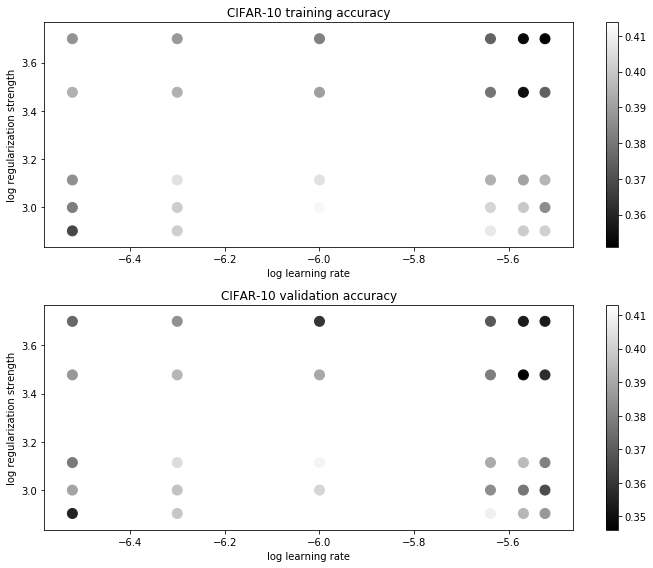

In [43]:
# Visualize the validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [44]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.415000


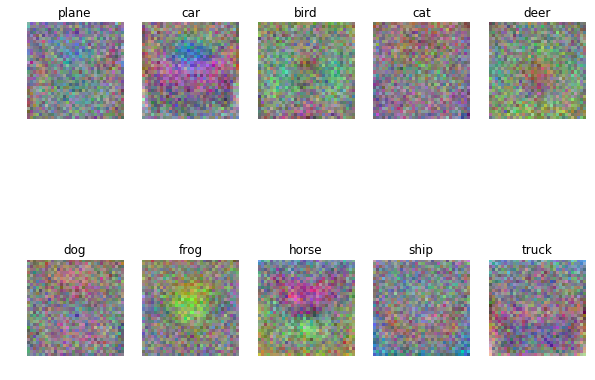

In [46]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline Question 3:
Describe what your visualized Softmax weights look like.

**Your answer:** *mean of the images*

## Save the model

When you are satisfied with your training, save the model for submission.

**Note**: You might get an error like this:

PicklingError: Can't pickle `<class 'dl4cv.classifiers.linear_classifier.Softmax'>`: it's not the same object as dl4cv.classifiers.linear_classifier.Softmax

The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.

In [47]:
from dl4cv.model_savers import save_softmax_classifier
save_softmax_classifier(best_softmax)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.4 \\
        \left(\frac{40}{\exp(0.4 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.4 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

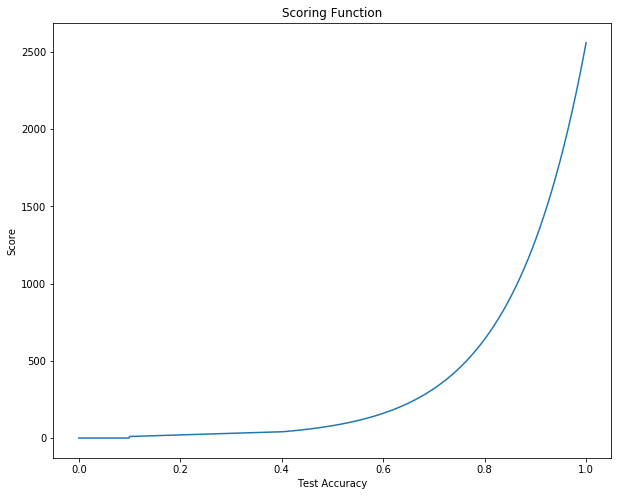

In [ ]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.4, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')